In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download1 = drive.CreateFile({'id': '1YDTb0DduoP_kQwmEm3d5CEQk3wDyPhfe'})
download1.GetContentFile('FER 2013.zip')

download2 = drive.CreateFile({'id': '1-Qpv3K7Q61XZr8zFTg20assEvSh5imi0'})
download2.GetContentFile('vgg16_weights.h5')

In [ ]:
ls

 adc.json  'FER 2013.zip'   sample_data/   vgg16_weights.h5


In [ ]:
import os
import zipfile

local_zip = '/content/FER 2013.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

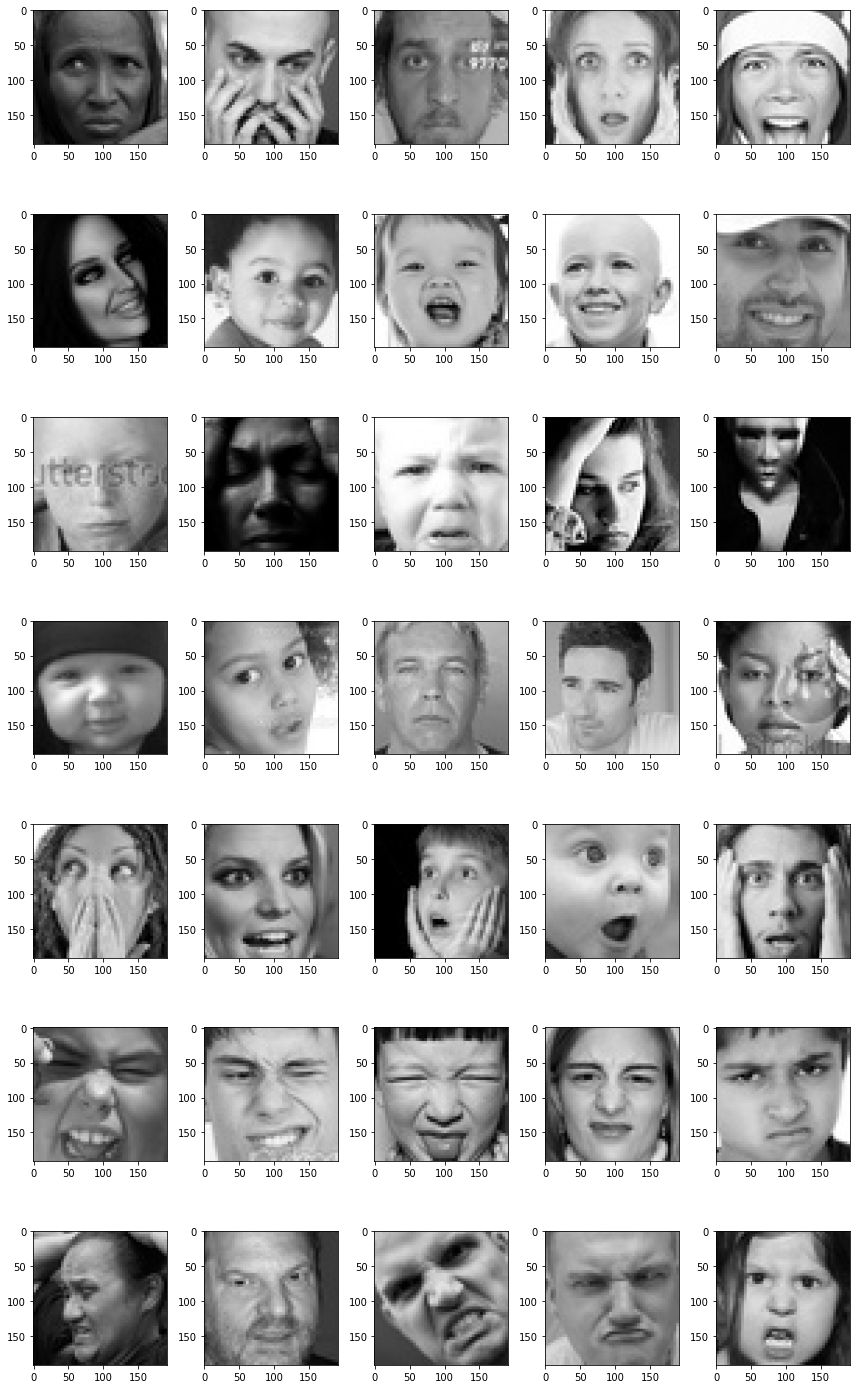

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

base_dir="/content/FER 2013/"

img_size = 192
plt.figure(0, figsize=(12,20))
ctr = 0

for expression in os.listdir(base_dir+"train/"):
    for i in range(1,6):
        ctr += 1
        plt.subplot(7,5,ctr)
        img = load_img(base_dir+"train/" + expression + "/" +os.listdir(base_dir+"train/"+ expression)[i], target_size=(img_size, img_size))
        plt.imshow(img)

plt.tight_layout()
plt.show()

In [ ]:
for expression in os.listdir(base_dir+"train/"):
    print(str(len(os.listdir(base_dir+"train/" + expression))) + " " + expression + " images")

4097 fear images
7215 happy images
4830 sad images
4965 neutral images
3171 surprise images
436 disgust images
3995 angry images


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
#from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
img_size = 192
batch_size = 32



datagen_train = ImageDataGenerator(rescale = 1.0/255., 

     featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    zoom_range=0.2
  )

train_generator = datagen_train.flow_from_directory(base_dir+"train/",
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical'
                                                    
                                                    )

datagen_validation  = ImageDataGenerator( rescale = 1.0/255.
                                         
    
   
  )
validation_generator = datagen_validation.flow_from_directory(base_dir+"test/",
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                             )

Tensorflow version: 2.2.0
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

  
from tensorflow.keras.applications.vgg16 import VGG16

local_weights_file = '/content/vgg16_weights.h5'

#main_input = layers.Input([48, 48, 1])

#e = layers.BatchNormalization()(main_input)
#e = layers.GaussianNoise(0.01)(e)
#input_tensor=e
pre_trained_model = VGG16(input_shape=(192,192,3) ,
    include_top = False, 
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()



#last_layer = pre_trained_model.get_layer('mixed7')
#print('last layer output shape: ', last_layer.output_shape)
#last_output = last_layer.output

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [ ]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

from tensorflow.keras.regularizers import l2


x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001),
           bias_regularizer=l2(0.001))(x)
x=layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)                  

x = layers.Dense(512, activation='relu',kernel_regularizer=l2(0.001),
           bias_regularizer=l2(0.001))(x)
x=layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x) 

x = layers.Dense (7, activation='softmax')(x)            





model = Model( pre_trained_model.input, x)
input_shape=(192,192,3)
model.build(input_shape) 
# Définition de l'optimizer (avec quelques paramètres qu'il faudra adapter à ses besoins)
#opt = RAdam(lr=0.1,total_steps=10000, warmup_proportion=0.1, min_lr=1e-6)
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size




reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                             patience=2, min_lr=0.0000001, mode='auto')
callbacks = [reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
   callbacks=callbacks
)




Epoch 1/30
897/897 [==============================] - 268s 299ms/step - loss: 2.2204 - accuracy: 0.3945 - val_loss: 1.7966 - val_accuracy: 0.4835 - lr: 5.0000e-04
Epoch 2/30
897/897 [==============================] - 269s 300ms/step - loss: 1.8364 - accuracy: 0.4616 - val_loss: 1.6723 - val_accuracy: 0.5035 - lr: 5.0000e-04
Epoch 3/30
897/897 [==============================] - 272s 303ms/step - loss: 1.7010 - accuracy: 0.4866 - val_loss: 1.6613 - val_accuracy: 0.4873 - lr: 5.0000e-04
Epoch 4/30
897/897 [==============================] - 274s 305ms/step - loss: 1.6376 - accuracy: 0.4953 - val_loss: 1.6455 - val_accuracy: 0.4936 - lr: 5.0000e-04
Epoch 5/30
897/897 [==============================] - 275s 307ms/step - loss: 1.5978 - accuracy: 0.5002 - val_loss: 1.6091 - val_accuracy: 0.4874 - lr: 5.0000e-04
Epoch 6/30
897/897 [==============================] - 276s 307ms/step - loss: 1.5652 - accuracy: 0.4991 - val_loss: 1.5825 - val_accuracy: 0.4940 - lr: 5.0000e-04
Epoch 7/30
897/897 [==

Text(0.5, 1.0, 'Training and validation loss')

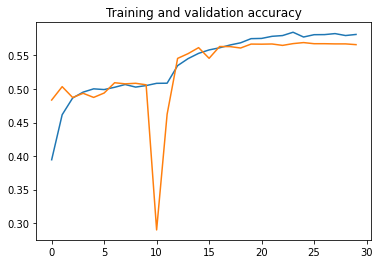

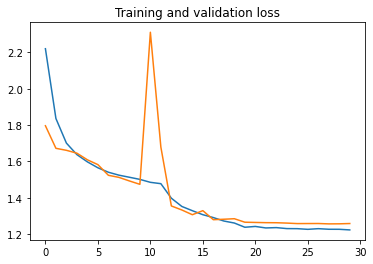

In [ ]:
model.save("mod.h5")

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion Matrix
[[ 417    9   71  150  147  139   25]
 [  28   37    2   16   11   15    2]
 [ 131    4  279  113  166  220  111]
 [  46    0   25 1475  126   64   38]
 [  68    6   46  178  757  148   30]
 [ 140    1   98  193  274  524   17]
 [  40    0   46   70   74   24  577]]


[Text(58.5, 0.5, 'True label'),
 Text(0.5, 107.09999999999997, 'Predicted label')]

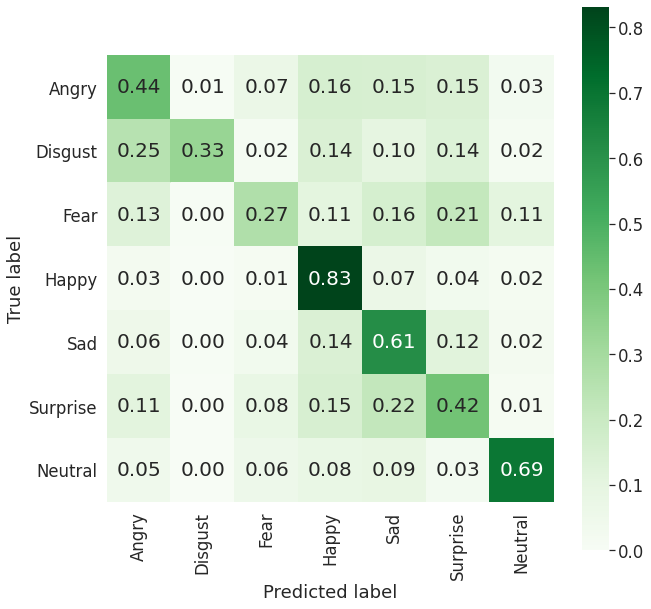

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
num_of_test_samples=7178
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_generator.classes, y_pred)
print(cm)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=True, 
                    cmap="Greens", yticklabels=emotion_labels, xticklabels=emotion_labels, vmin=0, vmax=np.max(cm_normalised), 
                    fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(192, 192))
  yy = image.img_to_array(img)
  yy = np.expand_dims(yy, axis=0)

  images = np.vstack([yy])
  classes = model.predict(images, batch_size=10)
  print(fn)

  print(np.argmax(classes[0]))

Saving S010_002_00000012.png to S010_002_00000012.png
S010_002_00000012.png
0
